# Analyzing the impact of investment in research and development on the movement of researchers

In [148]:
import pandas as pd

rd_df = pd.read_csv("../data/wbdata/R&D.csv")
rd_df

,year,country,r_and_d_percent
0,2023,Canada,1.70133
1,2022,Canada,1.71166
2,2021,Canada,1.86431
3,2020,Canada,1.93414
4,2019,Canada,1.75578
...,...,...,...
199,1994,United States,NaN
200,1993,United States,NaN
201,1992,United States,NaN
202,1991,United States,NaN


Reading the population size file

In [149]:
pop_data = pd.read_csv("../data/wbdata/Population.csv")
pop_data

,year,country,value
0,2023,Canada,40083484
1,2022,Canada,38935934
2,2021,Canada,38239864
3,2020,Canada,38028638
4,2019,Canada,37618495
...,...,...,...
199,1994,United States,263126000
200,1993,United States,259919000
201,1992,United States,256514000
202,1991,United States,252981000


In [ ]:
df_b = pd.read_csv("../data/moving_between_countries/country_year_metrics.csv")
target_countries = ["United States", "Germany", "United Kingdom", "China", "Canada", "Israel"]

target_years = [1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
# target_years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

# working copy and normalize year type
df_bal = df_b.copy()
df_bal["year"] = pd.to_numeric(df_bal["year"], errors="coerce").astype("Int64")

# calculate total leavers and arrivals
df_bal["left_total"] = df_bal["left_permanent"].fillna(0) + df_bal["left_temporary"].fillna(0)
arrived_sum = df_bal["arrived_permanent"].fillna(0) + df_bal["arrived_temporary"].fillna(0)
df_bal["arrived_total_final"] = df_bal["arrived_total"].fillna(arrived_sum)

# balance by migration type
df_bal["balance_permanent"] = df_bal["arrived_permanent"].fillna(0) - df_bal["left_permanent"].fillna(0)
df_bal["balance_temporary"] = df_bal["arrived_temporary"].fillna(0) - df_bal["left_temporary"].fillna(0)
df_bal["balance_overall"]   = df_bal["arrived_total_final"] - df_bal["left_total"]

# filter for requested countries and years
balance = (
    df_bal[df_bal["country"].isin(target_countries) & df_bal["year"].isin(target_years)]
    .loc[:, ["year", "country", "balance_permanent", "balance_temporary", "balance_overall"]]
    .sort_values(["year", "country"])
    .reset_index(drop=True)
)

balance


,year,country,balance_permanent,balance_temporary,balance_overall
0,1996,Canada,-3376,2627,-749
1,1996,China,-940,693,-247
2,1996,Germany,-2127,1929,-198
3,1996,Israel,-244,256,12
4,1996,United Kingdom,-3000,4150,1150
...,...,...,...,...,...
157,2022,China,41181,-28527,12654
158,2022,Germany,-7279,8936,1657
159,2022,Israel,-1351,1052,-299
160,2022,United Kingdom,-22817,21728,-1089


## Calculating normalized migration rate

In [ ]:
# ensure the column names match the expected format
pop_data = pop_data.rename(columns={"country_name": "country", "value": "population"})

# merge by year and country
merged = pd.merge(balance, pop_data, on=["year", "country"], how="inner")

# calculate per 1M inhabitants
for col in ["balance_permanent", "balance_temporary", "balance_overall"]:
    merged[f"{col}_per_million"] = merged[col] / merged["population"] * 1_000_000

# keep only relevant columns
balance_per_million = merged[[
    "year", "country",
    "balance_permanent_per_million",
    "balance_temporary_per_million",
    "balance_overall_per_million"
]]

balance_permanent = balance_per_million[['year', 'country', 'balance_permanent_per_million']]
balance_temporary = balance_per_million[['year', 'country', 'balance_temporary_per_million']]
balance_overall = balance_per_million[['year', 'country', 'balance_overall_per_million']]

balance_per_million

,year,country,balance_permanent_per_million,balance_temporary_per_million,balance_overall_per_million
0,1996,Canada,-114.014696,88.719374,-25.295322
1,1996,China,-0.772042,0.569176,-0.202866
2,1996,Germany,-25.965994,23.548849,-2.417145
3,1996,Israel,-42.867182,44.975404,2.108222
4,1996,United Kingdom,-51.575680,71.346357,19.770677
...,...,...,...,...,...
157,2022,China,29.161400,-20.200754,8.960646
158,2022,Germany,-86.863664,106.637409,19.773745
159,2022,Israel,-141.354957,110.070625,-31.284332
160,2022,United Kingdom,-337.509615,321.401101,-16.108514


In [36]:
# -*- coding: utf-8 -*-
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------
# Inputs:
# balance: DataFrame with columns ["year", "country", "balance_permanent_per_million"]
# rd_df:   DataFrame with columns ["year", "country", "r_and_d_percent"]
# --------------------------------------------

def build_chart_data(balance: pd.DataFrame, rd_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merge balance with R&D percent and return a tidy DataFrame with:
    year, country, r_and_d_percent, migration_per_million
    """
    # Standardize column names
    bal = balance.rename(columns={
        "balance_permanent_per_million": "migration_per_million"
    }).copy()

    # Ensure numeric
    bal["year"] = pd.to_numeric(bal["year"])
    rd = rd_df.copy()
    rd["year"] = pd.to_numeric(rd["year"])

    # Merge on year, country
    merged = pd.merge(
        bal[["year", "country", "migration_per_million"]],
        rd[["year", "country", "r_and_d_percent"]],
        on=["year", "country"],
        how="inner"
    )

    # Sort for neat lines
    merged = merged.sort_values(["country", "year"]).reset_index(drop=True)
    return merged



In [261]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text
import matplotlib.patheffects as pe

def plot_rd_vs_migration(df: pd.DataFrame, 
                         title: str = 'R&D spending vs normalized migration',
                         avg_years: int = 5,
                         label_every: int = 1,
                         arrow_scale: float = 0.02):
    """
    Multi-line chart: X = R&D % of GDP, Y = migration per million, one line per country.
    Average data over N-year windows. Labels shown only for years divisible by label_every.
    Labels are globally adjusted to avoid overlaps and connected to their points.
    Arrows indicate temporal direction between consecutive averaged points.
    """
    d = df.copy()
    d["year"] = d["year"].astype(int)

    plt.figure(figsize=(11, 7))
    ax = plt.gca()
    plt.margins(x=0.08, y=0.12)

    all_texts = []

    for country, g in d.groupby("country"):
        g = g.sort_values("year").reset_index(drop=True)

        # collapse into avg_years consecutive groups by positional index
        g2 = (
            g.assign(_group=(np.arange(len(g)) // avg_years))
             .groupby("_group", as_index=False)
             .agg(
                 year=("year", "mean"),
                 r_and_d_percent=("r_and_d_percent", "mean"),
                 migration_per_million=("migration_per_million", "mean"),
             )
        )
        g2["year"] = g2["year"].round().astype(int)

        # series arrays
        x = g2["r_and_d_percent"].to_numpy()
        y = g2["migration_per_million"].to_numpy()

        # plot the averaged line
        line = ax.plot(x, y, marker="o", lw=1.8, label=country)[0]

        # add small arrows to show time direction
        if len(x) > 1:
            dx = np.diff(x)
            dy = np.diff(y)
            ax.quiver(
                x[:-1], y[:-1], dx, dy,
                angles="xy", scale_units="xy", scale=1,
                width=0.004, headwidth=3, headlength=5,
                alpha=0.7, color=line.get_color(), zorder=3
            )


        # choose labels: only years divisible by label_every
        years = g2["year"].to_numpy()
        pick = (years % label_every == 0)
        sub = g2.loc[pick].reset_index(drop=True)

        # place labels at points. adjust_text will move and connect with a thin line
        for r in sub.itertuples():
            x0 = float(r.r_and_d_percent)
            y0 = float(r.migration_per_million)
            # two digit year label
            # year_2d = f"{int(r.year) % 100:02d}"
            year_2d = f"{int(r.year)}"

            t = ax.text(
                x0, y0, year_2d,
                fontsize=10, ha="center", va="center", clip_on=False,
                bbox=dict(boxstyle="round,pad=0.12", fc="white", ec="none", alpha=0.85),
            )
            t.set_path_effects([pe.withStroke(linewidth=2.5, foreground="white")])
            all_texts.append(t)

    # global de-overlap with connectors
    adjust_text(
        all_texts,
        only_move={"points": "xy", "texts": "xy"},
        expand_text=(1.12, 1.25),
        expand_points=(1.12, 1.25),
        force_text=0.6,
        force_points=0.5,
        arrowprops=dict(arrowstyle="-", lw=0.6, color="gray"),
        lim=600
    )

    ax.set_title(title, fontsize=16, weight="bold")
    ax.set_xlabel("R&D expenditure (% of GDP)", fontsize=16)
    ax.set_ylabel("Net researcher migration per million people", fontsize=16)
    ax.grid(True, linestyle="--", alpha=0.35)
    ax.legend(title="Country", fontsize=13, title_fontsize=13, loc="best")
    ax.tick_params(labelsize=14)
    plt.tight_layout()
    plt.show()


In [271]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text
import matplotlib.patheffects as pe

def plot_rd_vs_migration(df: pd.DataFrame, 
                         title: str = 'R&D spending vs normalized migration',
                         avg_years: int = 5,
                         label_every: int = 1,
                         arrow_size: float = 1.3):
    """
    Multi-line chart: X = R&D % of GDP, Y = migration per million, one line per country.
    Average data over N-year windows. Labels shown only for years divisible by label_every.
    Labels are globally adjusted to avoid overlaps and connected to their points.
    Arrows indicate temporal direction between consecutive averaged points.

    Parameters
    ----------
    avg_years : int
        Number of consecutive years to average (default 5).
    label_every : int
        Show label only for years divisible by this number (default 1, show all).
    arrow_size : float
        Controls arrow size multiplier. Smaller values = smaller arrows.
        Example: 0.5 (smaller), 1.0 (default), 2.0 (larger).
    """
    d = df.copy()
    d["year"] = d["year"].astype(int)

    plt.figure(figsize=(11, 7))
    ax = plt.gca()
    plt.margins(x=0.08, y=0.12)

    # add emphasized zero line
    ax.axhline(0, color="black", lw=1.2, ls="--", alpha=0.7, zorder=0)

    # add both major and minor grids
    ax.grid(True, which="major", ls="--", lw=0.8, alpha=0.35)
    ax.minorticks_on()
    ax.grid(True, which="minor", ls=":", lw=0.5, alpha=0.25)

    all_texts = []

    for country, g in d.groupby("country"):
        g = g.sort_values("year").reset_index(drop=True)

        # collapse into avg_years consecutive groups by positional index
        g2 = (
            g.assign(_group=(np.arange(len(g)) // avg_years))
             .groupby("_group", as_index=False)
             .agg(
                 year=("year", "mean"),
                 r_and_d_percent=("r_and_d_percent", "mean"),
                 migration_per_million=("migration_per_million", "mean"),
             )
        )
        g2["year"] = g2["year"].round().astype(int)

        # series arrays
        x = g2["r_and_d_percent"].to_numpy()
        y = g2["migration_per_million"].to_numpy()

        # plot the averaged line
        line = ax.plot(x, y, marker="o", lw=1.8, label=country)[0]

        # add arrows to show time direction
        if len(x) > 1:
            dx = np.diff(x)
            dy = np.diff(y)
            ax.quiver(
                x[:-1], y[:-1], dx, dy,
                angles="xy", scale_units="xy", scale=1,
                width=0.0025 * arrow_size, 
                headwidth=2.5 * arrow_size, 
                headlength=4 * arrow_size,
                alpha=0.7, color=line.get_color(), zorder=3
            )

        # choose labels: only years divisible by label_every
        years = g2["year"].to_numpy()
        pick = (years % label_every == 0)
        sub = g2.loc[pick].reset_index(drop=True)

        # place labels at points. adjust_text will move and connect with a thin line
        for r in sub.itertuples():
            x0 = float(r.r_and_d_percent)
            y0 = float(r.migration_per_million)
            year_full = str(int(r.year))  # full year

            t = ax.text(
                x0, y0, year_full,
                fontsize=10, ha="center", va="center", clip_on=False,
                bbox=dict(boxstyle="round,pad=0.12", fc="white", ec="none", alpha=0.85),
            )
            t.set_path_effects([pe.withStroke(linewidth=2.5, foreground="white")])
            all_texts.append(t)

    # global de-overlap with connectors
    adjust_text(
        all_texts,
        only_move={"points": "xy", "texts": "xy"},
        expand_text=(1.12, 1.25),
        expand_points=(1.12, 1.25),
        force_text=0.6,
        force_points=0.5,
        arrowprops=dict(arrowstyle="-", lw=0.6, color="gray"),
        lim=600
    )

    ax.set_title(title, fontsize=16, weight="bold")
    ax.set_xlabel("R&D expenditure (% of GDP)", fontsize=16)
    ax.set_ylabel("Net researcher migration per million people", fontsize=16)
    ax.legend(title="Country", fontsize=13, title_fontsize=13, loc="best")
    ax.tick_params(labelsize=14)
    plt.tight_layout()
    plt.show()


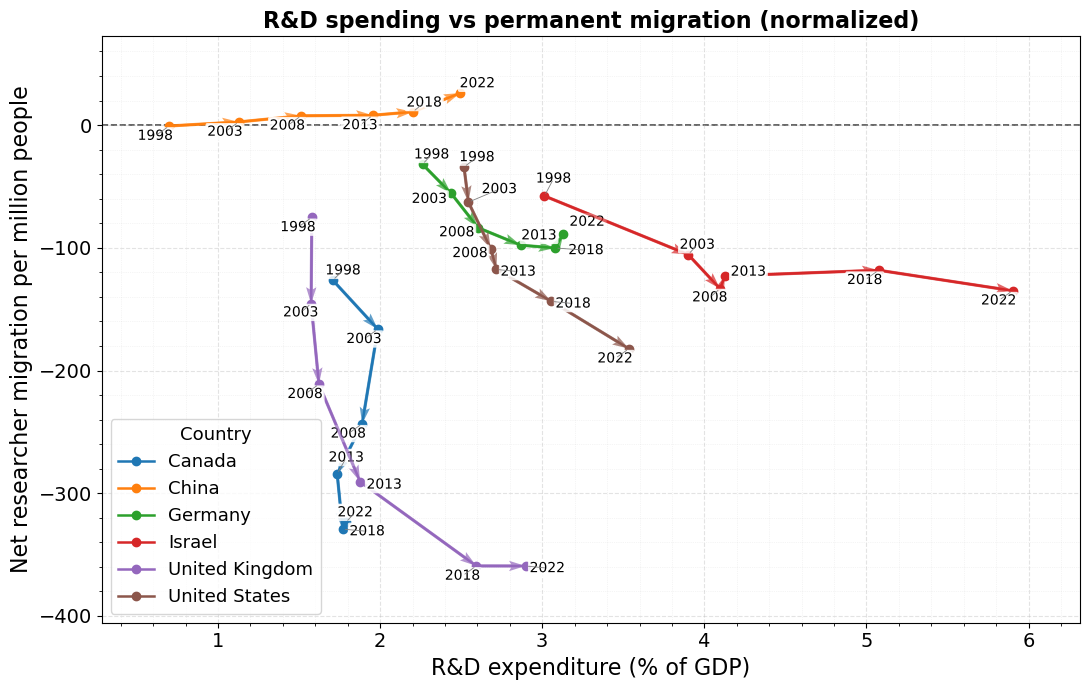

In [272]:
balance = balance_permanent.rename(columns={'balance_permanent_per_million': 'migration_per_million'})

merged = build_chart_data(balance, rd_df)
plot_rd_vs_migration(merged, title = 'R&D spending vs permanent migration (normalized)')
# export_chartjs_html(merged, out_path="researcher_migration_chart.html")

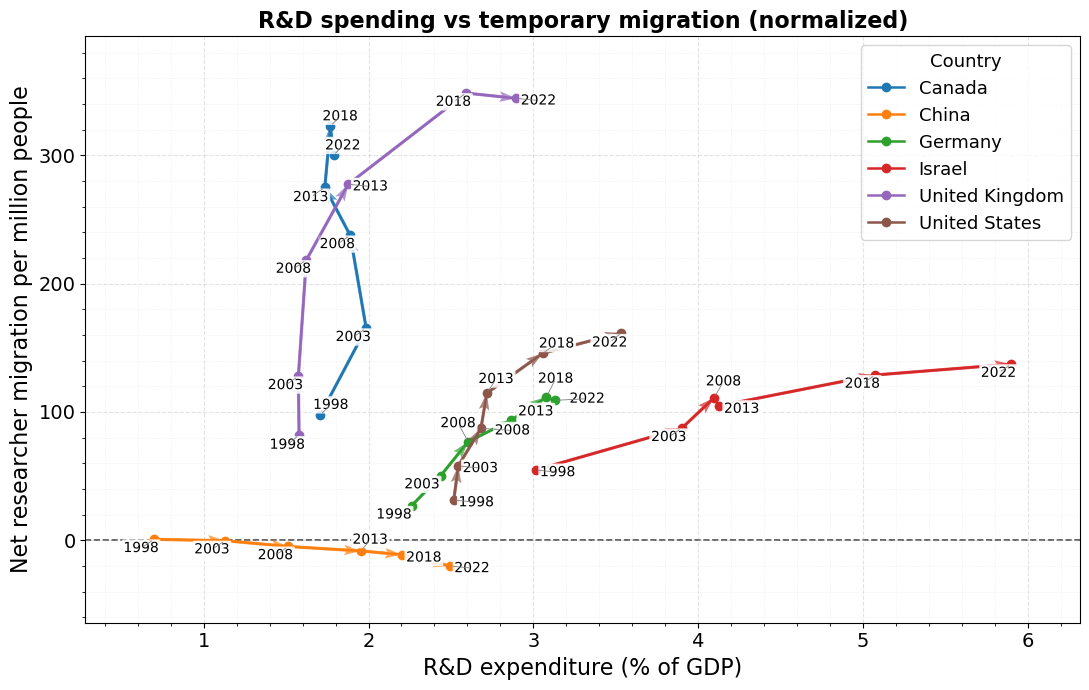

In [273]:
balance = balance_temporary.rename(columns={'balance_temporary_per_million': 'migration_per_million'})

merged = build_chart_data(balance, rd_df)
plot_rd_vs_migration(merged, title = 'R&D spending vs temporary migration (normalized)')
# export_chartjs_html(merged, out_path="researcher_migration_chart.html")

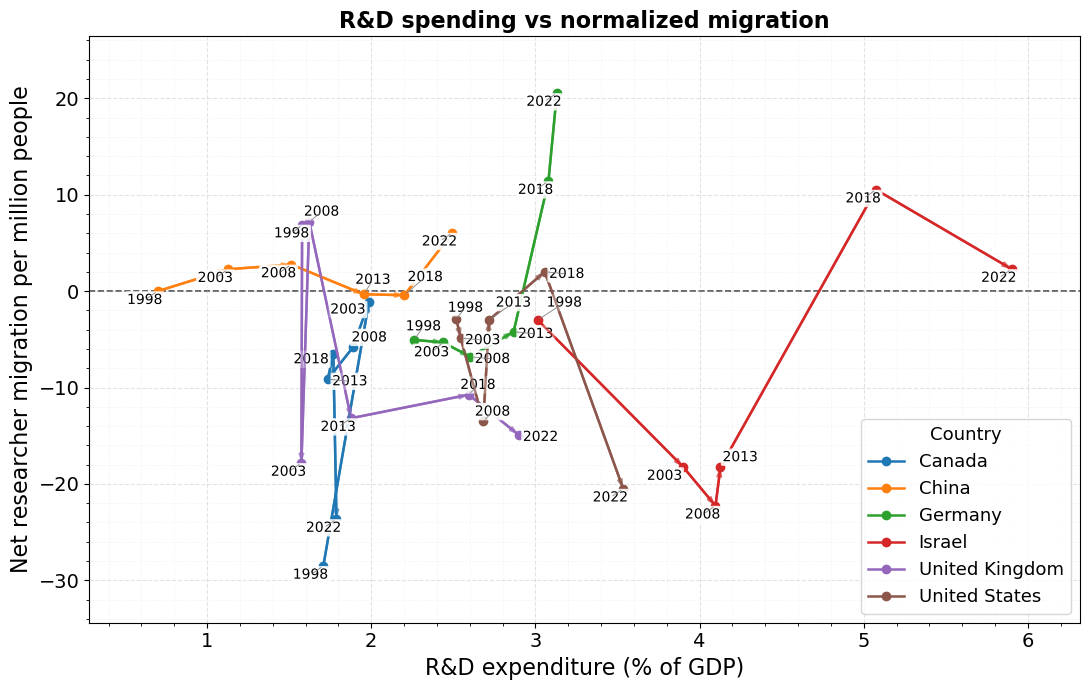

In [268]:
balance = balance_overall.rename(columns={'balance_overall_per_million': 'migration_per_million'})

merged = build_chart_data(balance, rd_df)
plot_rd_vs_migration(merged)
# export_chartjs_html(merged, out_path="researcher_migration_chart.html")

### Creating another interactive version of the chart in HTML

In [ ]:
def export_chartjs_html(merged: pd.DataFrame, out_path: str = "researcher_migration_chart.html"):
    """
    Create a standalone HTML file with Chart.js using the structure from your example.
    The data is embedded as JSON generated from the merged DataFrame.
    """
    # Build data dict: { "Israel": [ {year, r_and_d, migration}, ... ], ... }
    # You can keep English country names or map to Hebrew if you prefer.
    data_dict = {}
    for country, g in merged.groupby("country"):
        items = []
        for _, r in g.iterrows():
            items.append({
                "year": int(r["year"]),
                "r_and_d": float(r["r_and_d_percent"]),
                "migration_score": float(r["migration_per_million"]),
                # population is not needed here since already normalized per million
                "population": 1.0
            })
        data_dict[country] = items

    # Simple color palette
    colors = ['#3B82F6', '#10B981', '#F97316', '#8B5CF6', '#EF4444', '#F59E0B', '#14B8A6', '#0EA5E9', '#84CC16', '#A855F7']

    # HTML template
    template = f"""<!DOCTYPE html>
<html lang="en" dir="ltr">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>R&D spending vs normalized researcher migration</title>
<script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
<script src="https://cdn.tailwindcss.com"></script>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Assistant:wght@400;600;700&display=swap" rel="stylesheet">
<style>
  body {{ font-family: 'Assistant', sans-serif; background-color: #f8fafc; }}
</style>
</head>
<body class="bg-gray-50">
  <div class="container mx-auto p-4 sm:p-6 lg:p-8">
    <div class="bg-white p-6 rounded-2xl shadow-lg">
      <h1 class="text-2xl sm:text-3xl font-bold text-center text-gray-800 mb-2">R&D spending vs normalized researcher migration</h1>
      <p class="text-center text-gray-600 mb-6 max-w-3xl mx-auto">
        The chart shows the relationship between R&D spending and the net migration of researchers, normalized by population, expressed as net per million inhabitants.
      </p>
      <div class="w-full h-[500px] md:h-[600px]">
        <canvas id="researcherMigrationChart"></canvas>
      </div>
      <div class="mt-6 pt-4 border-t border-gray-200 text-sm text-gray-500">
        <h3 class="font-semibold text-lg text-gray-700 mb-2">How to read the chart:</h3>
        <ul class="list-disc list-inside space-y-1">
          <li><b>X axis:</b> R&D expenditure as a share of GDP.</li>
          <li><b>Y axis:</b> Net researcher migration per million inhabitants.</li>
          <li><b>Lines and points:</b> Each line represents a country over time.</li>
        </ul>
      </div>
    </div>
  </div>

  <script>
    const multiYearData = {json.dumps(data_dict, ensure_ascii=False)};

    const colors = {json.dumps(colors)};
    const datasets = Object.keys(multiYearData).map((country, index) => {{
        const color = colors[index % colors.length];
        return {{
            label: country,
            data: multiYearData[country].map(d => ({{
                x: d.r_and_d,
                y: d.migration_score,
                year: d.year
            }})),
            borderColor: color,
            backgroundColor: color,
            pointRadius: 6,
            pointHoverRadius: 9,
            borderWidth: 2.5,
            fill: false,
            tension: 0.1,
            showLine: true
        }};
    }});

    const ctx = document.getElementById('researcherMigrationChart').getContext('2d');
    const researcherMigrationChart = new Chart(ctx, {{
        type: 'line',
        data: {{ datasets }},
        options: {{
            responsive: true,
            maintainAspectRatio: false,
            plugins: {{
                legend: {{
                    position: 'top',
                    labels: {{ font: {{ family: 'Assistant', size: 14, weight: '600' }}, color: '#475569' }}
                }},
                tooltip: {{
                    callbacks: {{
                        title: function(context) {{
                            const dataPoint = context[0].raw;
                            const label = context[0].dataset.label;
                            return `${{label}} - ${{dataPoint.year}}`;
                        }},
                        label: function(context) {{
                            const dataPoint = context.raw;
                            return [
                                `R&D: ${{dataPoint.x.toFixed(2)}}% of GDP`,
                                `Normalized migration: ${{dataPoint.y.toFixed(1)}} per million`
                            ];
                        }}
                    }},
                    bodyFont: {{ family: 'Assistant', size: 14 }},
                    titleFont: {{ family: 'Assistant', size: 16, weight: 'bold' }},
                    rtl: false,
                    bodyAlign: 'left',
                    titleAlign: 'left'
                }}
            }},
            scales: {{
                x: {{
                    type: 'linear',
                    position: 'bottom',
                    title: {{
                        display: true,
                        text: 'R&D expenditure (% of GDP)',
                        font: {{ size: 16, weight: '600', family: 'Assistant' }},
                        color: '#334155'
                    }},
                    grid: {{ color: '#e2e8f0' }},
                    ticks: {{ color: '#475569' }}
                }},
                y: {{
                    title: {{
                        display: true,
                        text: 'Net researcher migration per million inhabitants',
                        font: {{ size: 16, weight: '600', family: 'Assistant' }},
                        color: '#334155'
                    }},
                    grid: {{ color: '#e2e8f0' }},
                    ticks: {{ color: '#475569' }}
                }}
            }}
        }}
    }});
  </script>
</body>
</html>
"""
    out_path = Path(out_path)
    out_path.write_text(template, encoding="utf-8")
    print(f"HTML written to: {out_path.resolve()}")
